In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import notebook

TensorFlow 1.x selected.


In [ ]:
(train_x, train_y), (test_x, test_y)=tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


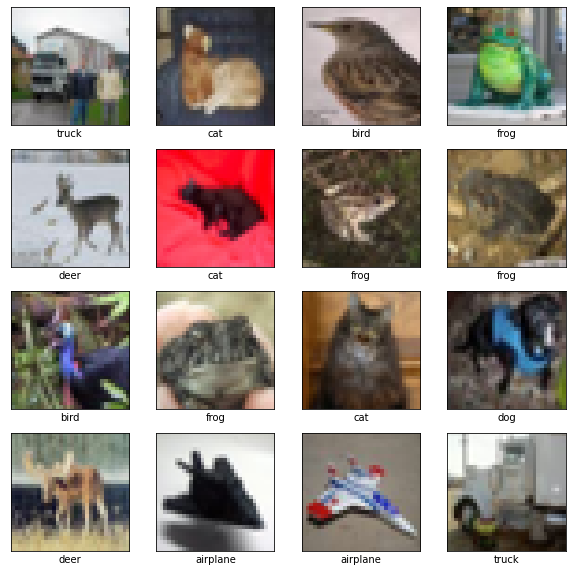

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_x[16+i], cmap=plt.cm.binary)
    plt.xlabel(classes[train_y[16+i][0]])
plt.show()

fig.savefig("cifar10.jpg")

In [ ]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Convolutional Neural Networks

In [ ]:
def onehot_encoding(y):
  classes=np.unique(y)
  y_onehot=[]
  for i in notebook.tqdm(y):
    a=[]
    for j in classes:
      if i==j:
        a.append(1.0)
      else:
        a.append(0.0)
    y_onehot.append(a)
  return np.array(y_onehot, dtype=np.float32).reshape(y.shape[0], len(classes))

In [ ]:
train_y_onehot, test_y_onehot = onehot_encoding(train_y), onehot_encoding(test_y)

In [ ]:
train_y_onehot.shape

(50000, 10)

In [ ]:
train_y_onehot[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
train_img_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=.0/255.0,
                                                                  horizontal_flip=True, 
                                                                  shear_range=0.2, 
                                                                  rotation_range=.25).flow(train_x, train_y_onehot.reshape(-1, 10), batch_size=32)                             
val_img_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=.0/255.0, 
                                                                  horizontal_flip=True, 
                                                                  shear_range=0.2, 
                                                                  rotation_range=.25).flow(test_x[:8000, :], test_y_onehot[:8000, :].reshape(-1, 10), batch_size=32)

In [ ]:
def train_model():
  with tf.device("/GPU:0"):
    x_inp = tf.keras.layers.Input(shape=(32, 32, 3))
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3),  activation="relu")(x_inp)
    
    x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)

    x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(64, activation="relu")(x)
    x=tf.keras.layers.Dense(32, activation="relu")(x)
    x_op=tf.keras.layers.Dense(10, activation="softmax")(x)

    return tf.keras.Model(inputs=x_inp, outputs=x_op)

In [ ]:
cifar_model=train_model()

In [ ]:
cifar_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 64)         

In [ ]:
cifar_model=train_model()
cifar_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                    loss=tf.keras.losses.CategoricalCrossentropy(), 
                    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()] )
history=cifar_model.fit_generator((train_img_generator), 
                                  steps_per_epoch=200, epochs=100, 
                                  validation_data=val_img_generator)


Epoch 1/100
200/200 [==============================] - 6s 32ms/step - loss: 0.9913 - accuracy: 0.6419 - precision_6: 0.7597 - recall_6: 0.5378 - val_loss: 24.6341 - val_accuracy: 0.6211 - val_precision_6: 0.7187 - val_recall_6: 0.5259
Epoch 2/100
200/200 [==============================] - 6s 31ms/step - loss: 0.9669 - accuracy: 0.6683 - precision_6: 0.7789 - recall_6: 0.5608 - val_loss: 1.1140 - val_accuracy: 0.6209 - val_precision_6: 0.7290 - val_recall_6: 0.5318
Epoch 3/100
200/200 [==============================] - 6s 31ms/step - loss: 0.9613 - accuracy: 0.6686 - precision_6: 0.7800 - recall_6: 0.5602 - val_loss: 1.0876 - val_accuracy: 0.6214 - val_precision_6: 0.7310 - val_recall_6: 0.5205
Epoch 4/100
200/200 [==============================] - 6s 31ms/step - loss: 0.9622 - accuracy: 0.6569 - precision_6: 0.7712 - recall_6: 0.5566 - val_loss: 1.1555 - val_accuracy: 0.6111 - val_precision_6: 0.6983 - val_recall_6: 0.5274
Epoch 5/100
200/200 [==============================] - 6s 31ms/

In [ ]:
test_acc = cifar_model.evaluate(test_x[8000:], test_y_onehot[8000:])

63/63 [==============================] - 0s 4ms/step - loss: 1.0057 - accuracy: 0.6555 - precision_6: 0.7401 - recall_6: 0.5795


In [ ]:
prediction=cifar_model.predict(test_x[:8])
prediction=np.argmax(prediction, axis=-1)
ground_truth=np.argmax(test_y_onehot[:8], axis=-1)
print(prediction, ' ', ground_truth)

[3 8 8 0 4 6 1 6]   [3 8 8 0 6 6 1 6]


In [ ]:
ground_truth=np.argmax(test_y_onehot[:8], axis=-1)

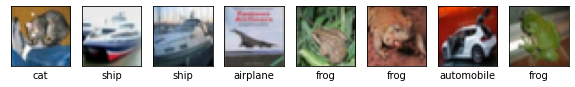

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(1, 8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_x[i], cmap=plt.cm.binary)
    plt.xlabel(classes[ground_truth[i]])
plt.show()

fig.savefig("ground_truth.pdf")

K-Nearest Neighbour

In [ ]:
tf.math.sqrt(tf.reduce_sum(tf.squared_difference(), axis=[1, 2, 3]))

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1 / 1
		 8 				 [8]


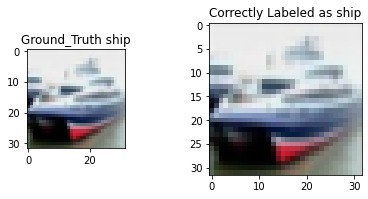

2 / 2
		 8 				 [8]


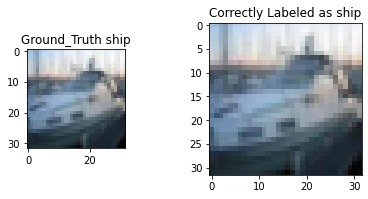

3 / 10
		 0 				 [0]


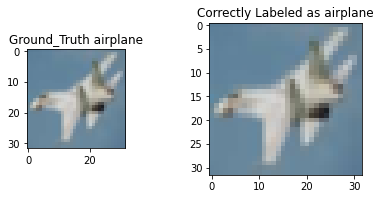

4 / 15
		 8 				 [8]


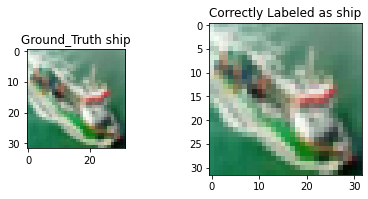

5 / 16
		 5 				 [5]


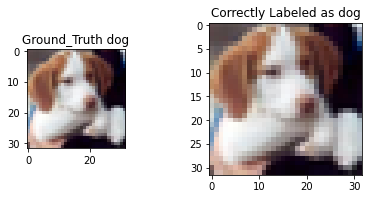

6 / 18
		 8 				 [8]


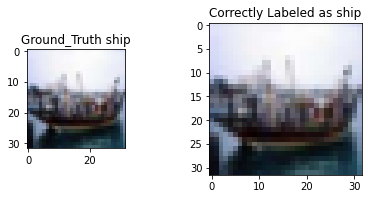

7 / 19
		 6 				 [6]


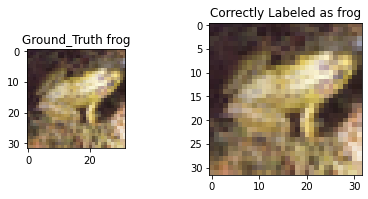

8 / 21
		 0 				 [0]


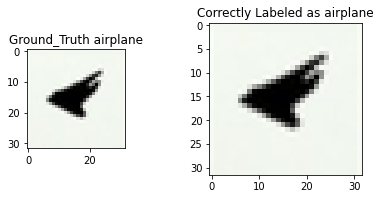

9 / 26
		 4 				 [4]


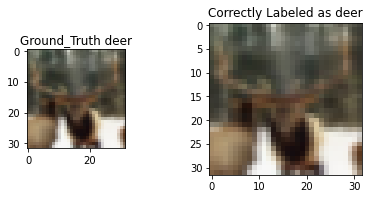

10 / 32
		 4 				 [4]


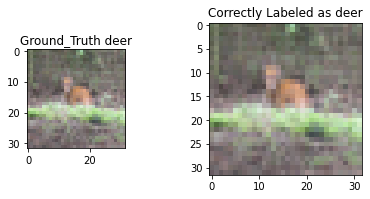

11 / 41
		 6 				 [6]


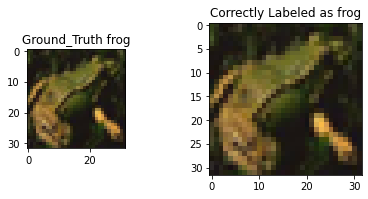

12 / 46
		 3 				 [3]


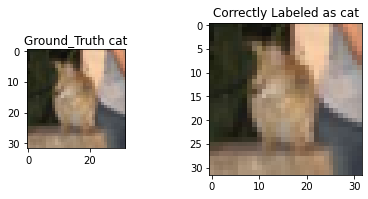

13 / 51
		 8 				 [8]


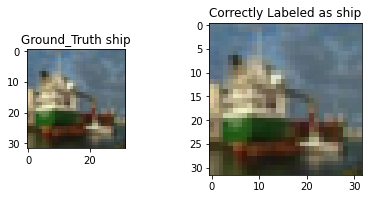

14 / 54
		 8 				 [8]


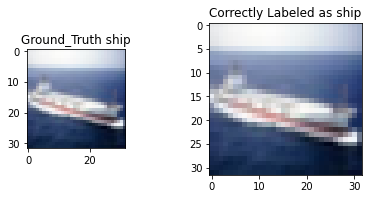

15 / 55
		 8 				 [8]


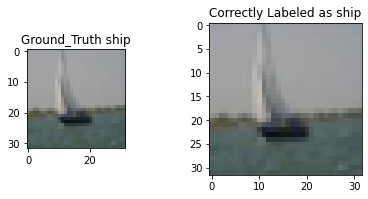

16 / 62
		 6 				 [6]


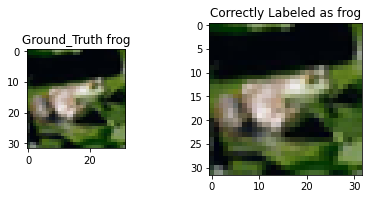

17 / 70
		 2 				 [2]


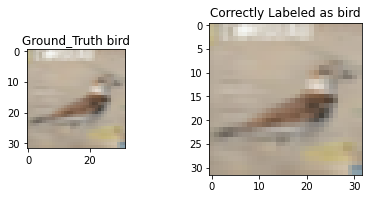

18 / 72
		 8 				 [8]


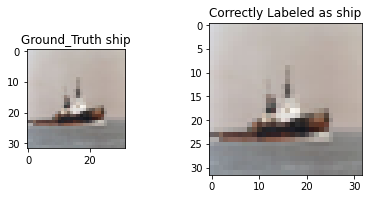

19 / 73
		 8 				 [8]


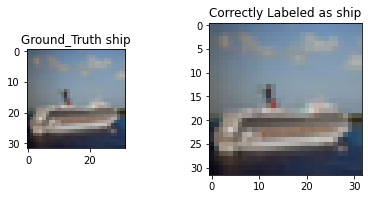

20 / 77
		 3 				 [3]


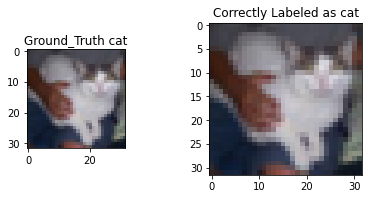

21 / 79
		 8 				 [8]


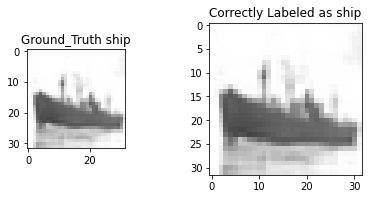

22 / 80
		 8 				 [8]


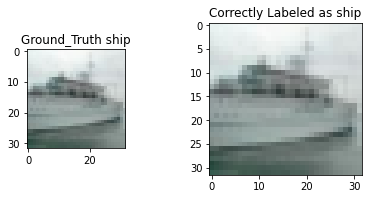

23 / 84
		 2 				 [2]


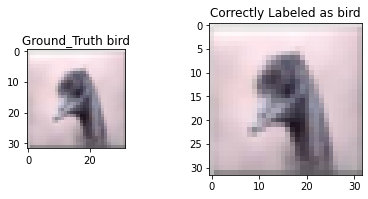

24 / 86
		 2 				 [2]


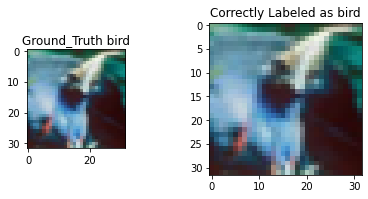

25 / 88
		 8 				 [8]


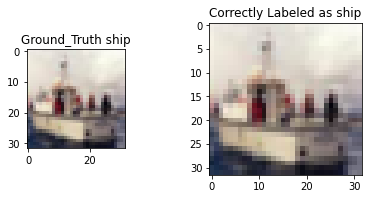

26 / 92
		 8 				 [8]


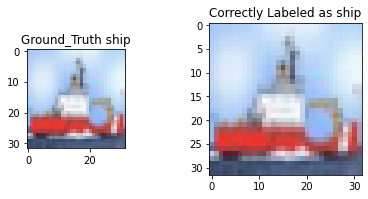

27 / 93
		 6 				 [6]


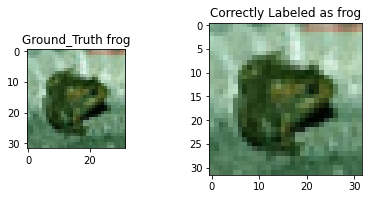

28 / 94
		 4 				 [4]


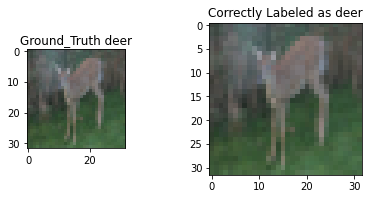

29 / 97
		 0 				 [0]


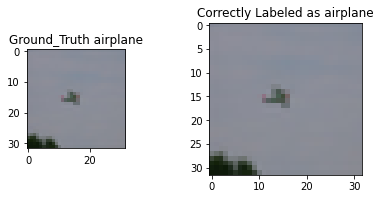

30 / 98
		 0 				 [0]


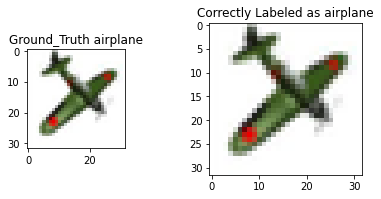

31 / 100
		 4 				 [4]


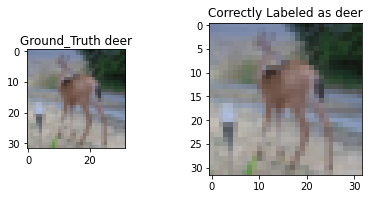

32 / 102
		 6 				 [6]


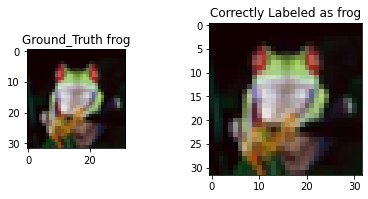

33 / 103
		 3 				 [3]


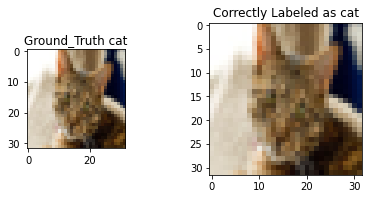

34 / 107
		 6 				 [6]


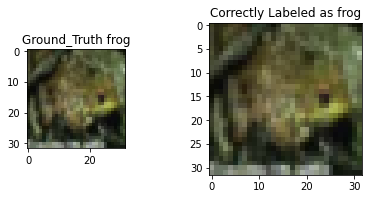

35 / 110
		 4 				 [4]


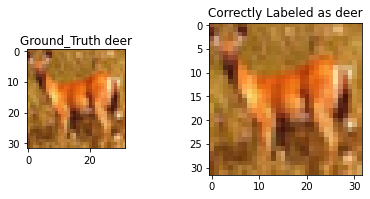

36 / 113
		 2 				 [2]


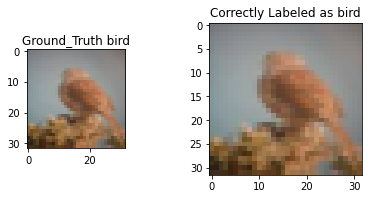

37 / 116
		 0 				 [0]


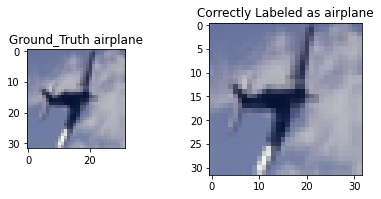

38 / 120
		 8 				 [8]


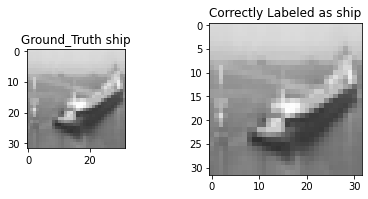

39 / 124
		 8 				 [8]


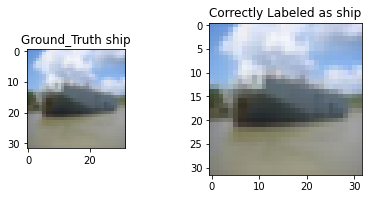

40 / 126
		 8 				 [8]


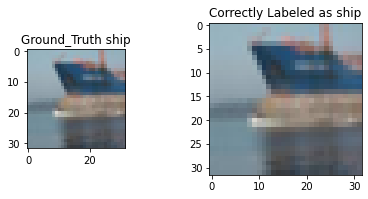

41 / 129
		 2 				 [2]


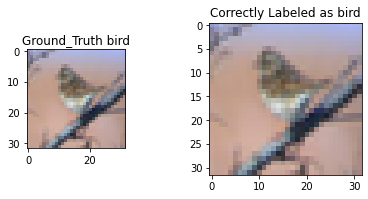

42 / 130
		 4 				 [4]


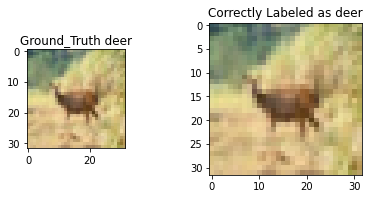

43 / 132
		 8 				 [8]


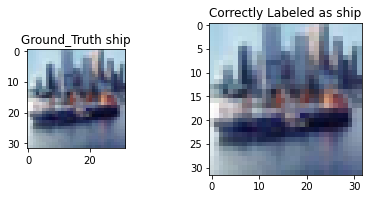

44 / 135
		 2 				 [2]


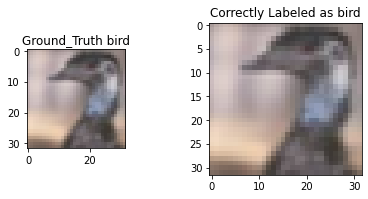

45 / 136
		 9 				 [9]


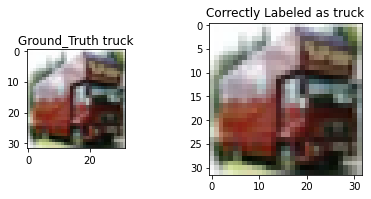

46 / 142
		 6 				 [6]


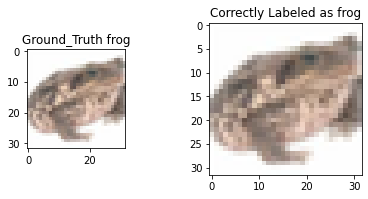

47 / 144
		 8 				 [8]


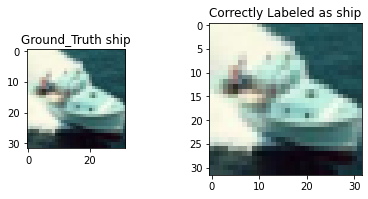

48 / 146
		 6 				 [6]


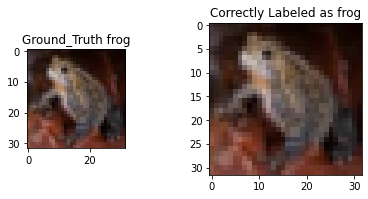

49 / 148
		 5 				 [5]


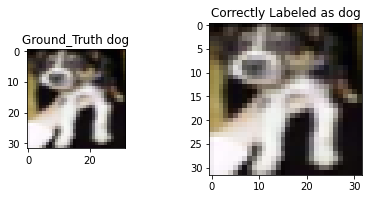

50 / 150
		 8 				 [8]


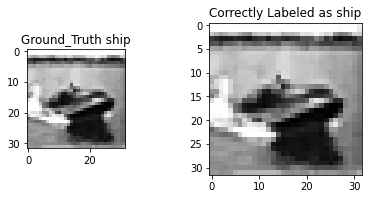

51 / 156
		 2 				 [2]


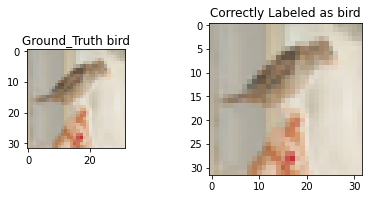

52 / 160
		 2 				 [2]


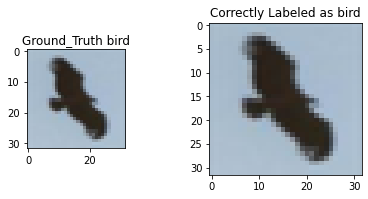

53 / 162
		 6 				 [6]


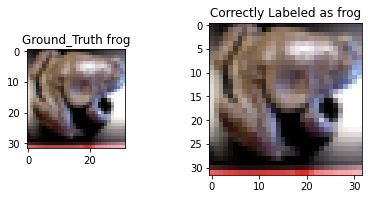

54 / 164
		 8 				 [8]


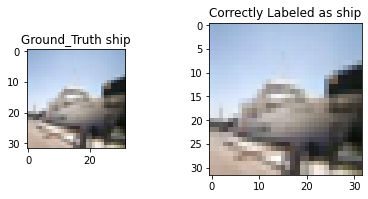

55 / 166
		 8 				 [8]


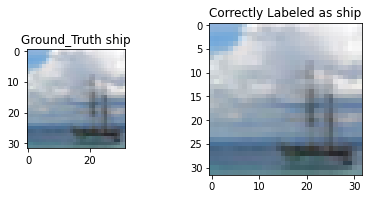

56 / 167
		 4 				 [4]


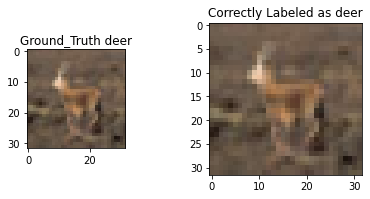

57 / 169
		 0 				 [0]


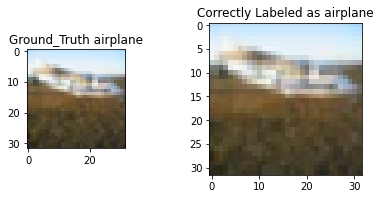

58 / 173
		 8 				 [8]


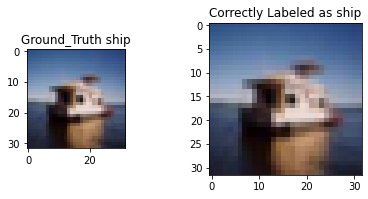

59 / 175
		 9 				 [9]


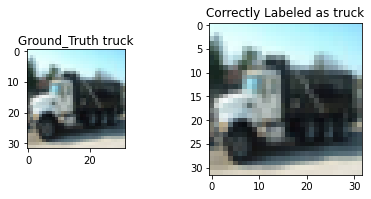

60 / 182
		 2 				 [2]


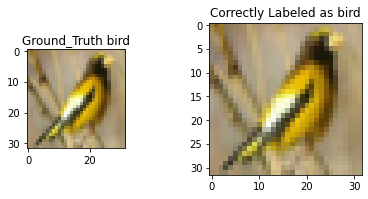

61 / 183
		 2 				 [2]


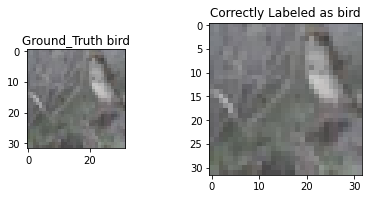

62 / 186
		 6 				 [6]


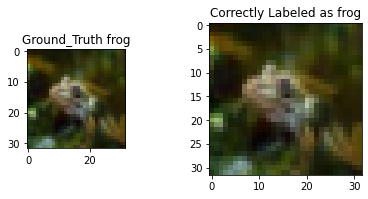

63 / 189
		 0 				 [0]


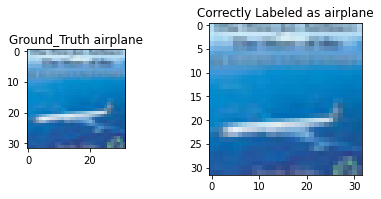

KeyboardInterrupt: ignored

In [ ]:
paramk = 100

x = tf.placeholder(tf.float32, shape=train_x.shape) 
y = tf.placeholder(tf.float32, shape=test_x.shape[1:])

# xThresholded = tf.clip_by_value(tf.cast(x, tf.int32), 0, 1) 
# yThresholded = tf.clip_by_value(tf.cast(y, tf.int32), 0, 1) 
compute_euc_dist = tf.math.sqrt(tf.reduce_sum(tf.squared_difference(x, y), axis=[1, 2, 3]))
# tf.print(tf.shape(compute_L0))
findKClosest_train_x = tf.contrib.framework.argsort(compute_euc_dist, direction='ASCENDING') 
findLabelsKClosest_train_x = tf.gather(train_y, findKClosest_train_x[0:paramk]) 
findULabels, findIdex, findCounts = tf.unique_with_counts(tf.squeeze(findLabelsKClosest_train_x)) 
findPredictedLabel = tf.gather(findULabels, tf.argmax(findCounts)) 

numErrs = 0
num_test_x = np.shape(test_y)[0]##change this for custom testing
num_train_x = np.shape(train_y)[0] 



with tf.Session() as sess:
  for i in range(0,num_test_x):
    predictedLabel = sess.run([findPredictedLabel], feed_dict={x:train_x.reshape(-1, 32, 32, 3),y:test_x[i].reshape( 32,32, 3)})   
    # print(np.array(predictedLabel).shape)
    # break
    if predictedLabel == test_y[i]:
      numErrs += 1
      print(numErrs,"/",i)
      print("\t\t", predictedLabel[0], "\t\t\t\t", test_y[i])
      
      if (True):
        plt.figure(1)
        plt.subplot(1,3,1)
        plt.imshow(test_x[i])
        plt.title('Ground_Truth '+ classes[int(test_y[i])])
        
        if test_y[i] == predictedLabel:
          plt.subplot(1,2,2)
          plt.imshow(test_x[i])
          plt.title('Correctly Labeled as '+classes[int(predictedLabel[0])])
          plt.draw()
        else:
          plt.subplot(1,2,2)
          plt.imshow(test_x[i])
          plt.title('wrongly Labeled as '+classes[int(predictedLabel[0])])
          plt.draw()
        plt.show()

print("# Classification Errors= ", numErrs, "% accuracy= ", 100.*(num_test_x-numErrs)/num_test_x)
      